In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
# we are using Surprise library which deals with explicit rating data
from surprise import Reader
from surprise import Dataset
from surprise import KNNWithMeans, SVD, NMF, SVDpp, SlopeOne, NormalPredictor, KNNBaseline, KNNBasic, KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
from surprise import accuracy
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Dataset, Reader, SVD, NMF
from surprise.model_selection import cross_validate, train_test_split
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


We need only the 'ratings' dataset for collaborative filtering.

In [5]:
ratings = pd.read_csv("ratings.csv")

## Data Exploration

In [144]:
print(ratings.head(5))

   userId  movieId  rating   timestamp
0       1      110     1.0  1425941529
1       1      147     4.5  1425942435
2       1      858     5.0  1425941523
3       1     1221     5.0  1425941546
4       1     1246     5.0  1425941556


This dataset has 4 columns. We need only 3 of them: userId, movieId, and rating.

In [145]:
print(ratings.info()) 
print(ratings.describe())
print(ratings.nunique())
print(ratings.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB
None
             userId       movieId        rating     timestamp
count  2.602429e+07  2.602429e+07  2.602429e+07  2.602429e+07
mean   1.350371e+05  1.584911e+04  3.528090e+00  1.171258e+09
std    7.817620e+04  3.108526e+04  1.065443e+00  2.052889e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    6.716400e+04  1.073000e+03  3.000000e+00  9.907545e+08
50%    1.351630e+05  2.583000e+03  3.500000e+00  1.151716e+09
75%    2.026930e+05  6.503000e+03  4.000000e+00  1.357578e+09
max    2.708960e+05  1.762750e+05  5.000000e+00  1.501830e+09
userId         270896
movieId         45115
rating             10
timestamp    20549435
dtype: int64
(26024289, 4)


- userID and movieID columns' values are all int64 type and rating values are float64 type, which is ideal for our use.
- rating values range from 0.5 to 5.0.
- there are 270,896 users and 45,115 different movies in this dataset. 
- we have 26,024,289 movie ratings in total.

In [146]:
ratings.isnull().any()

userId       False
movieId      False
rating       False
timestamp    False
dtype: bool

'ratings' dataset does not have any missing values.

In [147]:
init_notebook_mode(connected=True)

number_ratings = ratings['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = number_ratings.index,
               text = ['{:.1f} %'.format(val) for val in (number_ratings.values / ratings.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = number_ratings.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie ratings'.format(ratings.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

#https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

In [148]:
r_per_movie = ratings.groupby('movieId')['rating'].count().sort_values(ascending = False)
r_per_movie[r_per_movie >= 1000]

movieId
356      91921
318      91082
296      87901
593      84078
2571     77960
         ...  
78088     1004
7017      1002
6650      1000
6763      1000
5105      1000
Name: rating, Length: 3747, dtype: int64

There are 3747 movies that have more than 1000 ratings.

Since the rating dataset we have is clean enough for our purposes, we will proceed without much data cleaning and pre-processing.

In [6]:
ratings = ratings[:100000] #the dataset is too large and the code is running too slow, so trying out the code with a small subset

<h1> Using Surprise library </h1>

In [150]:
# Set up Reader object and load dataset into Surprise's Dataset object

reader = Reader(rating_scale=(0.5, 5))
rating_reader = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [151]:
# Split dataset into training and testing datasets
trainset, testset = train_test_split(rating_reader, test_size=0.2)

In [152]:
# Train algorithm using cosine similarity and user-based approach
sim_options_user_based = {'name': 'cosine', 'user_based': True}
knn_user_based = KNNWithMeans(sim_options=sim_options_user_based)
knn_user_based.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [153]:
# Predict rating for a specific user and movie (example)
user_id = 42 #random user
movie_id = 123 #random movie
predicted_rating = knn_user_based.predict(user_id, movie_id).est
print(f'Predicted rating for user {user_id} and movie {movie_id} with used-based filtering: {predicted_rating}')

Predicted rating for user 42 and movie 123 with used-based filtering: 3.770904935709382


In [154]:
#recommend unseen movies to users

def recommend_movies_user_based(user_id, k=15, n=10):
    # Get k most similar users to given user
    similar_users = knn_user_based.get_neighbors(user_id, k=k)

    # Get movies rated highly by similar users that given user hasn't rated
    movies = {}
    for user in similar_users:
        for movie in ratings[ratings['userId'] == user]['movieId'].values:
            if movie not in ratings[ratings['userId'] == user_id]['movieId'].values:
                rating = ratings[(ratings['userId'] == user) & (ratings['movieId'] == movie)]['rating'].values[0]
                if movie in movies:
                    movies[movie]['rating'] += rating
                    movies[movie]['count'] += 1
                else:
                    movies[movie] = {'rating': rating, 'count': 1}

    # Sort recommended movies by average rating
    sorted_movies = sorted(movies.items(), key=lambda x: x[1]['rating']/x[1]['count'], reverse=True)

    # Return top n recommended movies
    return [movie[0] for movie in sorted_movies[:n]]

In [155]:
# Recommend 5 movies to a specific user (example)
user_id = 8
k = 10
n = 5
recommended_movies = recommend_movies_user_based(user_id, k, n)
print(f'{n} recommended movies for user {user_id}: {recommended_movies}')

5 recommended movies for user 8: [29, 246, 1225, 1354, 2529]


Evaluating the performance

In [156]:
predictions = knn_user_based.test(testset)
rmse_knn_userbased = accuracy.rmse(predictions, verbose=True)
print(f'rmse of knn of user based filtering is {rmse_knn_userbased}')

RMSE: 0.8984
rmse of knn of user based filtering is 0.8984208037127079


Tuning the Algorithm Parameters

We are using GridSearchCV to try out different parameters and determine the best parameters for rmse.

In [157]:
# Setting up parameter grid for grid search
param_grid = {'k': [5, 10, 15, 20], 'sim_options': {'name': ['cosine', 'pearson']}}

# Performing grid search
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=5)
gs.fit(rating_reader)

# Printing best RMSE score and parameters
print(f'Best RMSE score: {gs.best_score["rmse"]}')
print(f'Best parameters: {gs.best_params["rmse"]}')

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computi

As a result of the GridSearchCV, we determined that user-based collaborative filtering used with cosine similary metrics works best on our dataset. 

### Experimenting with different algorithms

In [158]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, rating_reader, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is depreca

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/vq/r13xv8cj2gj29pdtj9rfqt4h0000gn/T/ipykernel_28224/937417117.py:9: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.867623,11.247500,4.025811
BaselineOnly,0.874445,0.062464,0.074450
SVD,0.878746,0.358997,0.112621
KNNBaseline,0.882770,0.106921,1.525610
KNNWithZScore,0.896124,0.087602,1.456134
KNNWithMeans,0.896495,0.054987,1.230117
SlopeOne,0.902247,1.485403,3.313461
NMF,0.930241,0.763555,0.101880
KNNBasic,0.941750,0.041270,1.240794


SVDpp gave us the best rmse but the fit time of SVDpp is extremely high compared to other algorithms. However, baselineOnly algorithm has both good rmse and time efficiency. So, we are choosing BaselineOnly algorithm as our model.

In [159]:
# Train algorithm using cosine similarity and user-based approach
sim_options_user_based = {'name': 'cosine', 'user_based': True}
baseline_user_based = BaselineOnly(sim_options_user_based)
baseline_user_based.fit(trainset)

Estimating biases using als...


In [160]:
predictions = baseline_user_based.test(testset)
rmse_baseline_userbased = accuracy.rmse(predictions, verbose=True)
print(f'rmse of knn of user based filtering is {rmse_baseline_userbased}')

RMSE: 0.8756
rmse of knn of user based filtering is 0.8755936724477474


### Trying out implementing the collaborative filtering manually to see if it will reduce the runtime.

## Manual Implementation

In [7]:
#pivot function is having issues with a large dataset
pivot_data = pd.pivot_table(ratings, index='movieId', columns='userId', values='rating')

In [8]:
pivot_data.head()

userId,1,2,3,4,5,6,7,8,9,10,...,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.5,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
pivot_data.shape

(8832, 1014)

In [27]:
pivot_data.fillna(0,inplace=True)

### Removing Noise from the data

To qualify a movie, a minimum of 10 users should have voted a movie.

To qualify a user, a minimum of 50 movies should have voted by the user.

In [28]:
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

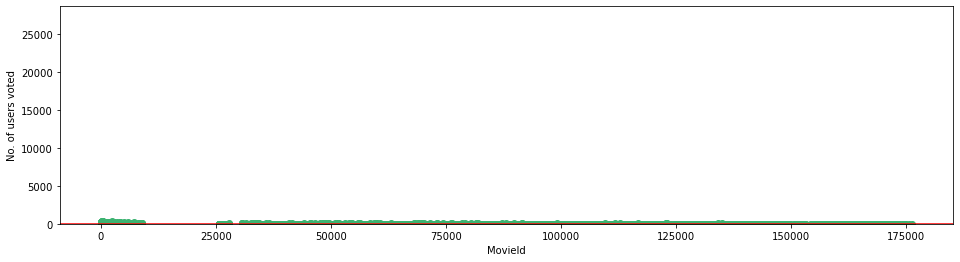

In [29]:
#Visualizing the number of users who voted with our threshold of 10.
f,ax = plt.subplots(1,1,figsize=(16,4))
ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [30]:
final_dataset = pivot_data.loc[no_user_voted[no_user_voted > 10].index,:]

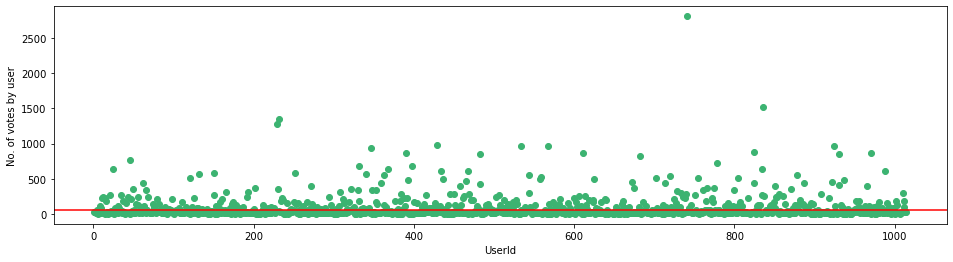

In [31]:
#visualizing the number of votes by each user with our threshold of 50.
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

In [32]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]

### Removing sparsity


In [33]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [70]:
final_dataset

userId,movieId,4,7,8,9,11,12,15,16,20,...,992,993,997,998,999,1002,1003,1010,1011,1012
0,1,0.0,0.0,4.0,4.5,0.0,4.0,0.0,0.0,4.0,...,0.0,5.0,0.0,0.0,0.0,3.0,0.0,4.0,4.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,3.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,148626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009,152081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2010,164179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011,166528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
#applying svd
#matrix = final_dataset.values
#u, s, vh = svd(matrix, full_matrices=False)

In [43]:
#def cosine_similarity(v,u):
 #   return (v @ u)/ (np.linalg.norm(v) * np.linalg.norm(u))

In [46]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
def recommend_movies_manual(user_id, k=15, n=10):
    # Get k most similar users to given user
    similar_users = knn.kneighbors(user_id, k=k)

    # Get movies rated highly by similar users that given user hasn't rated
    movies = {}
    for user in similar_users:
        for movie in ratings[ratings['userId'] == user]['movieId'].values:
            if movie not in ratings[ratings['userId'] == user_id]['movieId'].values:
                rating = ratings[(ratings['userId'] == user) & (ratings['movieId'] == movie)]['rating'].values[0]
                if movie in movies:
                    movies[movie]['rating'] += rating
                    movies[movie]['count'] += 1
                else:
                    movies[movie] = {'rating': rating, 'count': 1}

    # Sort recommended movies by average rating
    sorted_movies = sorted(movies.items(), key=lambda x: x[1]['rating']/x[1]['count'], reverse=True)

    # Return top n recommended movies
    return [movie[0] for movie in sorted_movies[:n]]

Final version

In [2]:
ratings = pd.read_csv("ratings.csv")

In [4]:
ratings = ratings.sample(2000000)

In [5]:
# Set up Reader object and load dataset into Surprise's Dataset object

reader = Reader(rating_scale=(0.5, 5))
rating_reader = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [6]:
# Split dataset into training and testing datasets
trainset, testset = train_test_split(rating_reader, test_size=0.2)

In [7]:
# Train algorithm using cosine similarity and user-based approach
sim_options_user_based = {'name': 'cosine', 'user_based': True}
baseline_user_based = BaselineOnly(sim_options_user_based)
baseline_user_based.fit(trainset)

Estimating biases using als...


In [8]:
predictions = baseline_user_based.test(testset)
rmse_baseline_userbased = accuracy.rmse(predictions, verbose=True)
print(f'rmse of knn of user based filtering is {rmse_baseline_userbased}')

RMSE: 0.9049
rmse of knn of user based filtering is 0.9048931170546217
